ใน ep ก่อน ๆ ที่เราสร้างโมเดลมา จะเป็นโมเดลแบบ Classification คือ ไม่ว่า Input จะเป็นรูปภาพ ข้อความ ข้อมูลตาราง ให้โมเดลจำแนกหมวดหมู่ Output ของโมเดล ก็จะถูกจำกัดอยู่ภายใน ตัวเลือก Class ที่เป็น Choice ที่เรากำหนดเท่านั้น เช่น "0", "1", "2", "3", "4" ..., "9", หมา, แมว, ป่าไม้, แม่น้ำ, แง่บวก, แง่ลบ, 1 ดาว, 2 ดาว, 3 ดาว..., 5 ดาว, รายได้เกิน 50k USD, รายได้ต่ำกว่า 50k USD

แต่ในเคสนี้ เราจะสร้างโมเดลแบบ Regression คือ โมเดลที่ Output เป็นค่าต่อเนื่อง หมายถึง ให้ตอบเป็นค่าอะไรก็ได้ ในช่วงที่กำหนด สมมติว่า 0-5 ก็จะเป็นค่าอะไรก็ได้ เช่น 1.555555, 2.3456789, 0.0000000002865, 4.99999999999999 แต่ใน Dataset นี้คือ ตำแหน่งพิกัด x, y ของจุดศูนย์กลางของหัว

# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.tensorboard import *
import time

# 2. ข้อมูล

เราจะใช้ชุดข้อมูล [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db) label คือตำแหน่งจุดศูนย์กลางของหัว ในแต่ละภาพ เก็บข้อมูลโดยอุปกรณ์ Kinect แสกนภาพ 3 มิติ.

ชุดข้อมูลนี้ประกอบด้วย รูปถ่าย ของ 20 คน (ชาย 14 หญิง 6 - มี 4 คน ที่ถ่ายซ้ำ) จำนวนรวม 15,000 รูป ทุกรูปมีขนาด 640x480 Pixel องศาก้มเงย +-60 องศา องศาหันซ้ายขวา +-75 องศา

Ground Truth ที่ให้มาคือ ตำแหน่งพิกัด 3 มิติ และ องศาการหมุนก้มเงย หันซ้ายขวาของหัว

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path

PosixPath('/home/jupyter/.fastai/data/biwi_head_pose')

แบ่งเป็น Folder เป็นเลข Running

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/20.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/03'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/16.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/23.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/18'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/02.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/22.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/15'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/11'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/08'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/22'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/20'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/24.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/06.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/02'),
 PosixPa

ลองดู 10 ไฟล์แรก จาก 1000 ไฟล์ ใน Folder 01

In [5]:
filenames = get_files(path/'01')
len(filenames), filenames[:10]

(1000,
 [PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00294_rgb.jpg'),
  PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00244_pose.txt'),
  PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00313_rgb.jpg'),
  PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00089_rgb.jpg'),
  PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00214_pose.txt'),
  PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00474_rgb.jpg'),
  PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00438_pose.txt'),
  PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00434_rgb.jpg'),
  PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00117_pose.txt'),
  PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00410_rgb.jpg')])

โครงสร้าง Folder จะเป็นดังนี้

- 01.obj
- 01
    - rgb.cal
    - frame_00001_pose.txt
    - frame_00001_rgb.txt
    - frame_00002_pose.txt
    - frame_00002_rgb.txt
    - frame_00003_pose.txt
    - frame_00003_rgb.txt
    - ...
- 02.obj
- 02
    - rgb.cal
    - fname_...


ในทุก Folder จะมีไฟล์พิเศษ คือ rgb.cal เป็นข้อมูล Calibate ของกล้อง Kinect ต้องนำข้อมูลพิกัดในไฟล์ _pose.txt มาเข้าสูตร ประกอบกัน จึงจะออกมาเป็นพิกัด x, y

In [6]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

ลองดูรูปตัวอย่าง

In [7]:
fname = '03/frame_00333_rgb.jpg'

ฟังชัดแปลงชื่อรูป เป็นชื่อไฟล์พิกัด

In [8]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

เปิดไฟล์รูป

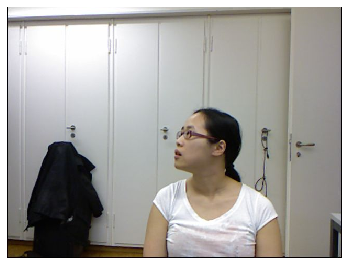

In [9]:
img = open_image(path/fname)
img.show(figsize=(6, 6))

ฟังก์ชันแปลงพิกัดในไฟล์ เป็นพิกัด x, y, z

In [10]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([ 59.1235,  25.5755, 907.652 ])

In [11]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

ลองเรียกฟังก์ชันแปลงพิกัด จุดกึ่งกลางหัว ของรูปด้านบน

In [12]:
get_ctr(fname)

tensor([255.0870, 353.7211])

แสดงรูป พร้อม Overlay จุดกึ่งกลางหัว ที่คำนวนได้

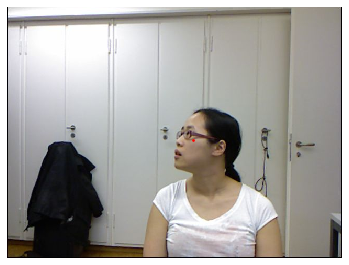

In [13]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

# 3. เตรียมข้อมูล



1. ใช้ PointsItemList สำหรับงาน จุดตำแหน่งพิกัด
2. เราจะเอา Folder 03 เป็น Validation Set ด้วย Lambda ฟังก์ชันที่ส่งให้ split_by_valid_func
3. label เราก็จะใช้ฟังก์ชัน get_ctr ที่เขียนไว้ด้านบนอีก เช่นกัน
4. สำหรับข้อมูลรูปคน เราสามารถ flip ซ้าย ขวา ได้ แต่ ขึ้น ลง ไม่ได้ จะทำให้ผิดความหมายไป เราสามารถใช้ Default get_transforms ได้เลย, tfm_y=True เมื่อ transform รูปภาพ ให้ transform จุด Label ด้วยจะได้ match กัน 
5. ย่อรูปเป็นขนาด size (120, 160) ก็พอ เราไม่จำเป็นต้องใช้รูปละเอียดมาก

In [14]:
batchsize = 64
np.random.seed(0)
transform = get_transforms()

databunch = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='03')
        .label_from_func(get_ctr)
        .transform(transform, tfm_y=True, size=(120,160))
        .databunch(bs=batchsize).normalize(imagenet_stats)
       )

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label ไว้บนรูป แสดง 3 แถว (rows) ในกรอบขนาด 10 x 10 นิ้ว (figsize) ข้อมูลจะถูก transform ทุกครั้งที่เรียก เราจะได้รูปที่ไม่เหมือนกันในแต่ละครั้ง ถึงแม้จะเป็นรูปเดียวกันก็ตาม เป็นเรื่อง Data Augmentation จะอธิบายต่อไป 

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

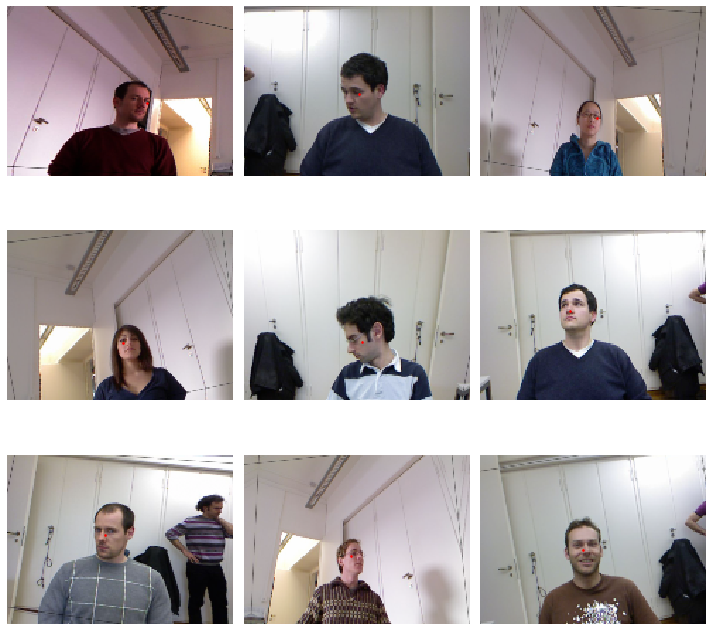

In [15]:
databunch.show_batch(rows=3, figsize=(10, 10))

# 4. สร้างโมเดล

งานไม่ค่อยซับซ้อน เราจะใช้ resnet34

In [16]:
learner = cnn_learner(databunch, models.resnet34, 
                     callback_fns=ShowGraph)

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 4 Cycle

epoch,train_loss,valid_loss,time
0,0.160432,0.020182,00:50
1,0.017533,0.025307,00:50
2,0.012480,0.021164,00:50
3,0.010050,0.017568,00:50


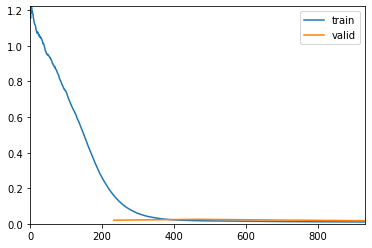

In [17]:
learner.fit_one_cycle(4)

# 6. เทรนต่อ

In [18]:
learner.unfreeze()

epoch,train_loss,valid_loss,time
0,0.005953,0.001482,00:50
1,0.002344,0.001403,00:52
2,0.001343,0.000706,00:51


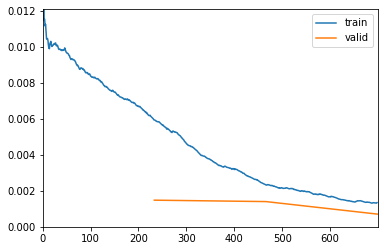

In [19]:
learner.fit_one_cycle(3, max_lr=slice(1e-6, 3e-3))

## สำเร็จแล้ว ##

เพียงแค่เวลา 7 นาที เราเทรน Model เรียบร้อย


# 7. ดูผลลัพธ์

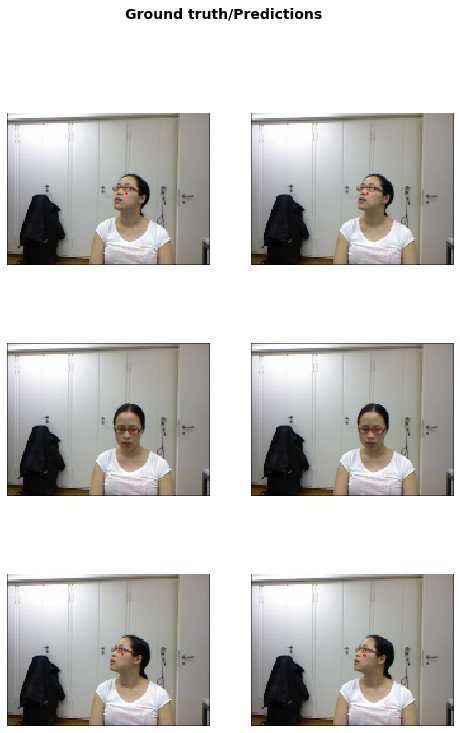

In [20]:
learner.show_results(rows=3)

# 9. สรุป


1. เราสามารถสร้างโมเดล Regression ได้ง่าย ๆ ด้วยชุดข้อมูลรูปภาพที่มี label, โค้ดไม่กี่บรรทัด และ GPU ไม่กี่นาที
2. โมเดลแบบนี้สามารถนำไปประยุกต์ใช้ได้หลากหลาย เช่น ทำนายราคาบ้าน ราคาสินค้า อุณหภูมิ ปริมาณยา สารเคมีที่ใช้ etc. ที่เราต้องการ Output ที่เป็นตัวเลข ที่เป็นค่าต่อเนื่อง

# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 3](https://course.fast.ai/videos/?lesson=3)
* [Biwi Kinect Head Pose Database. Credit Fanelli, Gabriele and Dantone, Matthias and Gall, Juergen and Fossati, Andrea and Van Gool, Luc](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db)